In [100]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import gsw
import src.helper as helper
import src.mooring 
import src.read_CTDs

In [101]:
#help(helper);

In [102]:
file_path = "/media/sf_VM_Folder/data/moorings/supermooring.mat"
struct = sio.loadmat(file_path, squeeze_me = True)
data = struct["mooring"]
data.dtype

dtype([('INSTITUTE', 'O'), ('INST_COUNTRY', 'O'), ('MOORINGID', 'O'), ('LAT', 'O'), ('LON', 'O'), ('WATERDEPTH', 'O'), ('CRUISE', 'O'), ('LEG', 'O'), ('SHIP', 'O'), ('INSTRUMENTTYPE', 'O'), ('SN', 'O'), ('STARTDATE', 'O'), ('INSTRUMENTDEPTH', 'O'), ('DATETIME', 'O'), ('DEPTH', 'O'), ('PRES', 'O'), ('TEMP', 'O'), ('SALT', 'O'), ('SPD', 'O'), ('DIR', 'O'), ('UC', 'O'), ('VC', 'O'), ('SA', 'O'), ('CT', 'O'), ('potemp', 'O'), ('potdens', 'O'), ('gamma_n', 'O')])

In [103]:
#load necessary data into usable variables
lat_list = np.squeeze(data["LAT"])
lon_list = np.squeeze(data["LON"])
depth_list = np.squeeze(data["DEPTH"])
pressure_list = np.squeeze(data["PRES"])
u_list = np.squeeze(data["UC"])
v_list = np.squeeze(data["VC"])
SA_list = np.squeeze(data["SA"])
Temp_list = np.squeeze(data["TEMP"])

#Convert matlab time arrays to arrays filled with python datetime objects
time_list = []
for i in range(lat_list.size):
    mtime = np.squeeze(data["DATETIME"])[i]
    time_list.append([helper.matlab2datetime(tval) for tval in mtime.flatten().tolist()])
#time_list = np.asarray(time_list)

In [104]:
# Create dictionary with the depth of the deepest mooring per longitude value
max_depth_dict = {}
for i in range(lat_list.size):
    _depth = np.mean(np.squeeze(depth_list[i]))
    _lon = float(np.squeeze(lon_list[i]))
    
    try:
        if _depth > max_depth_dict[_lon]:
            max_depth_dict[_lon] = _depth
    except KeyError:
        max_depth_dict[_lon] = _depth

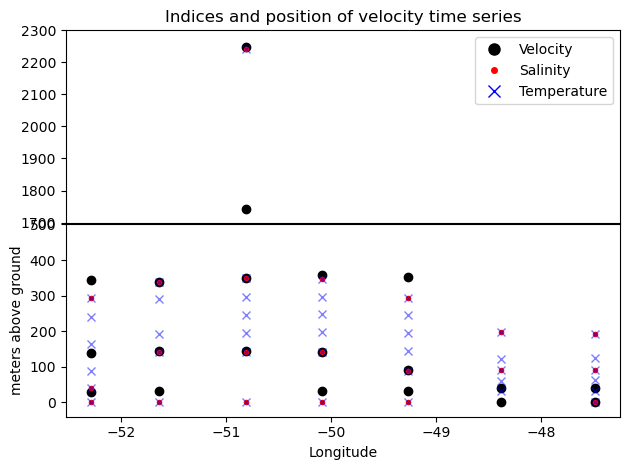

In [105]:
f,a = plt.subplots(nrows = 2, sharex = True)

for i in range(lat_list.size):

    _depth = np.mean(np.squeeze(depth_list[i]))
    _lon = float(np.squeeze(lon_list[i]))
    
    #Condition if the time series contains actual data
    u_condition = not np.all(np.isnan(np.squeeze(u_list[i])))
    SA_condition = not np.all(np.isnan(np.squeeze(SA_list[i])))
    Temp_condition = not np.all(np.isnan(np.squeeze(Temp_list[i])))

    #shallow sensors are plotted in the upper subplot, deep sensors are plotted in the lower subplot
    if abs(_depth-max_depth_dict[_lon]) > 1000: axi = 0
    else: axi = 1
    

    #Plot marker if measurements of that variable exists
    if u_condition:
        #a[axi].plot(_lon,abs(_depth-max_depth_dict[_lon]),".", alpha = 0.3)
        #a[axi].text(_lon, abs(_depth-max_depth_dict[_lon]), str(i), ha = "center", va = "center")
        
        a[axi].plot(_lon,abs(_depth-max_depth_dict[_lon]),"ko", zorder = 0)

    if SA_condition:
        a[axi].plot(_lon,abs(_depth-max_depth_dict[_lon]),".r", zorder = 5)
    if Temp_condition:
        a[axi].plot(_lon,abs(_depth-max_depth_dict[_lon]),"xb", zorder = 10, alpha = 0.5)

        
#Draw legend with the 3 markers for the 3 different measurement variables
u_marker = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=8, label='Velocity')
s_marker = mlines.Line2D([], [], color='red', marker='.', linestyle='None', markersize=8, label='Salinity')
t_marker = mlines.Line2D([], [], color='blue', marker='x', linestyle='None', markersize=8, label='Temperature')
a[0].legend(handles=[u_marker,s_marker,t_marker])    

a[0].set_ylim(1700,2300)
a[1].set_ylim(-40,500)
a[1].set_ylabel("meters above ground")
a[1].set_xlabel("Longitude")
a[0].set_title("Indices and position of velocity time series")
f.tight_layout()
f.subplots_adjust(hspace = 0.01)

# Sorting into moorings

In [106]:
#create list of all locations of the time series
list_of_locations = list(zip(lat_list.flatten(), lon_list.flatten()))
#select all unique pairs of lat,lon tuples
unique_locations = list(dict.fromkeys(list_of_locations)) 
#sort after their longitude
unique_locations.sort(key=lambda x: x[1])
print(f"{unique_locations = }")
unique_locations = np.array(unique_locations)

unique_locations = [(-63.4032, -52.287), (-63.5145, -51.6357), (-63.656, -50.8113), (-63.7783, -50.0897), (-63.917, -49.2682), (-64.0665, -48.3805), (-64.2157, -47.4903)]


In [107]:
mooring_temp_data = [{"lat":location[0], "lon":location[1]} for location in unique_locations]
mooring_temp_pressure_data = [{"lat":location[0], "lon":location[1]} for location in unique_locations]

mooring_sal_data = [{"lat":location[0], "lon":location[1]} for location in unique_locations]
mooring_sal_data

[{'lat': -63.4032, 'lon': -52.287},
 {'lat': -63.5145, 'lon': -51.6357},
 {'lat': -63.656, 'lon': -50.8113},
 {'lat': -63.7783, 'lon': -50.0897},
 {'lat': -63.917, 'lon': -49.2682},
 {'lat': -64.0665, 'lon': -48.3805},
 {'lat': -64.2157, 'lon': -47.4903}]

In [108]:
def get_mooring_number(longitude,moorings):
    for i,mooring in enumerate(moorings):
        if longitude == mooring["lon"]:
            return i

for i,_ in enumerate(lat_list):

    average_depth = np.mean(np.squeeze(depth_list[i]))
    lon = np.squeeze(lon_list[i])
    mooring_number = get_mooring_number(lon, mooring_temp_data)

    salinity = np.squeeze(SA_list[i])
    pressure = np.squeeze(pressure_list[i])
    temperature = np.squeeze(Temp_list[i])
    time = time_list[i]
    
    #Condition if the time series contains actual data
    # u_condition = not np.all(np.isnan(np.squeeze(u_list[i])))
    SA_condition = not np.all(np.isnan(salinity))
    if SA_condition:
        series = pd.Series(index = time, data = salinity)
        daily_series = series.resample('D').mean()
        mooring_sal_data[mooring_number][int(f"{average_depth:.0f}")] = daily_series
    
    Temp_condition = not np.all(np.isnan(temperature))
    if Temp_condition:
        series = pd.Series(index = time, data = temperature)
        daily_series = series.resample('D').mean() #daily average
        mooring_temp_data[mooring_number][int(f"{average_depth:.0f}")] = daily_series

        series = pd.Series(index = time, data = pressure)
        daily_pressure_series = series.resample('D').mean()
        mooring_temp_pressure_data[mooring_number][int(f"{average_depth:.0f}")] = daily_pressure_series

In [109]:
temperature_data = []
for data in mooring_temp_data:
    mooring = src.mooring.Mooring(data)
    mooring.location = (mooring["lat"].iloc[0], mooring["lon"].iloc[0])
    if "lat" in mooring.columns:
        mooring.drop(columns = ["lat","lon"], inplace = True)

    extended_mooring = mooring.T.reindex(range(mooring.T.index.min(),mooring.T.index.max()+1))
    interpolated_mooring = extended_mooring.interpolate(method='index', axis='index', limit_area = 'inside')
    temperature_data.append(interpolated_mooring)

pressure_data_at_temperature_coordinates = []
for data in mooring_temp_pressure_data:
    mooring = src.mooring.Mooring(data)
    mooring.location = (mooring["lat"].iloc[0], mooring["lon"].iloc[0])
    if "lat" in mooring.columns:
        mooring.drop(columns = ["lat","lon"], inplace = True)

    extended_mooring = mooring.T.reindex(range(mooring.T.index.min(),mooring.T.index.max()+1))
    interpolated_mooring = extended_mooring.interpolate(method='index', axis='index',limit_area = 'inside')
    pressure_data_at_temperature_coordinates.append(interpolated_mooring)
    
salinity_data = []
for data in mooring_sal_data:
    mooring = src.mooring.Mooring(data)
    mooring.location = (mooring["lat"].iloc[0], mooring["lon"].iloc[0])
    if "lat" in mooring.columns:
        mooring.drop(columns = ["lat","lon"], inplace = True)

    extended_mooring = mooring.T.reindex(range(mooring.T.index.min(),mooring.T.index.max()+1))
    interpolated_mooring = extended_mooring.interpolate(method='index', axis='index',limit_area = 'inside')
    salinity_data.append(interpolated_mooring)

In [110]:
len(temperature_data)

7

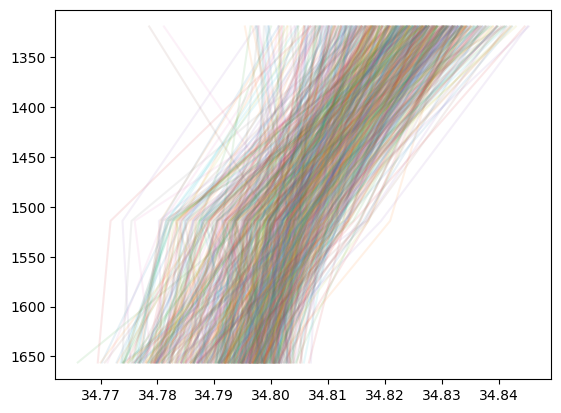

In [111]:
for col in salinity_data[1].columns:
    plt.plot(salinity_data[1][col], salinity_data[1].index, alpha = 0.1)
plt.gca().invert_yaxis()    

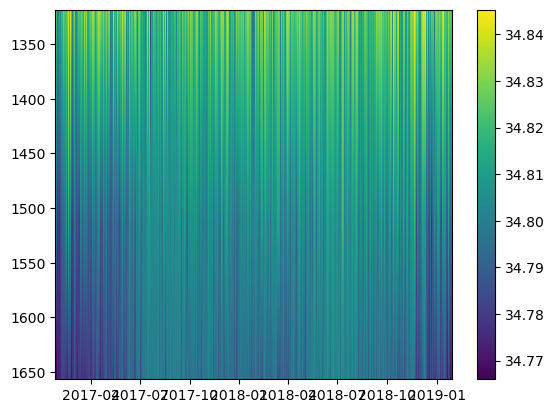

In [112]:
plt.pcolormesh(salinity_data[1].columns, salinity_data[1].index, salinity_data[1].values, cmap='viridis')
plt.colorbar()
plt.gca().invert_yaxis()

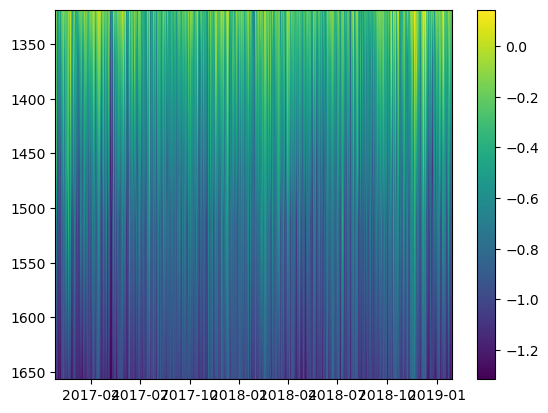

In [113]:
plt.pcolormesh(temperature_data[1].columns, temperature_data[1].index, temperature_data[1].values, cmap='viridis')
plt.colorbar()
plt.gca().invert_yaxis()

In [114]:
# set up DataFrames for the conservative temperature and N^2
# conservative_temperature_data = [src.mooring.Mooring() for mooring in temperature_data]  
nsquared_data = [src.mooring.Mooring() for mooring in temperature_data]  

# iterate over all 7 moorings and calculate conservative temperature (CT)
for i, (T, p, SA) in enumerate(zip(temperature_data, pressure_data_at_temperature_coordinates, salinity_data)):

    assert np.all(T.index == p.index)
    assert np.all(T.columns == p.columns)
    assert T.location == SA.location
    # Get the common index and columns
    common_index = T.index.intersection(SA.index)
    common_columns = T.columns.intersection(SA.columns)
    
    # Select the common data from both DataFrames
    T_common = T.loc[common_index, common_columns]
    SA_common = SA.loc[common_index, common_columns]
    p_common = p.loc[common_index, common_columns]
    
    CT_common = gsw.conversions.CT_from_t(SA=SA_common,t=T_common,p=p_common)
    CT_common.location = SA_common.location
    # conservative_temperature_data[i] = CT_common

    Nsquared, p_mid = gsw.Nsquared(SA=SA_common,CT=CT_common,p=p_common) #,lat=T_common.location[0])
    Nsquared = src.mooring.Mooring(index = SA_common.index[1:] + 0.5, columns = SA_common.columns, data = Nsquared)
    Nsquared.location = SA_common.location
    nsquared_data[i] = Nsquared

In [115]:
Nsquared

,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-28,2017-01-29,2017-01-30,2017-01-31,2017-02-01,...,2019-01-18,2019-01-19,2019-01-20,2019-01-21,2019-01-22,2019-01-23,2019-01-24,2019-01-25,2019-01-26,2019-01-27
3968.5,-1.738854e-07,-2.864631e-07,-1.463010e-07,-1.244504e-07,-1.283781e-07,-1.647671e-07,-1.037547e-07,-1.021251e-07,2.176521e-07,-2.509891e-08,...,4.388819e-07,4.503630e-07,5.248826e-07,4.987784e-07,5.095868e-07,3.680803e-07,3.565736e-07,3.391080e-07,3.793825e-07,4.923356e-07
3969.5,-1.737721e-07,-2.863382e-07,-1.461956e-07,-1.243587e-07,-1.282863e-07,-1.646822e-07,-1.036609e-07,-1.020267e-07,2.178270e-07,-2.496365e-08,...,4.389907e-07,4.504702e-07,5.249956e-07,4.988865e-07,5.096982e-07,3.681708e-07,3.566594e-07,3.391956e-07,3.794717e-07,4.924433e-07
3970.5,-1.736587e-07,-2.862133e-07,-1.460902e-07,-1.242671e-07,-1.281946e-07,-1.645973e-07,-1.035672e-07,-1.019282e-07,2.180019e-07,-2.482839e-08,...,4.390995e-07,4.505775e-07,5.251086e-07,4.989947e-07,5.098096e-07,3.682612e-07,3.567451e-07,3.392831e-07,3.795610e-07,4.925510e-07
3971.5,-1.735454e-07,-2.860885e-07,-1.459848e-07,-1.241755e-07,-1.281028e-07,-1.645124e-07,-1.034734e-07,-1.018297e-07,2.181768e-07,-2.469313e-08,...,4.392083e-07,4.506848e-07,5.252215e-07,4.991028e-07,5.099210e-07,3.683517e-07,3.568309e-07,3.393706e-07,3.796503e-07,4.926587e-07
3972.5,-1.734320e-07,-2.859636e-07,-1.458794e-07,-1.240838e-07,-1.280111e-07,-1.644274e-07,-1.033796e-07,-1.017312e-07,2.183518e-07,-2.455787e-08,...,4.393171e-07,4.507920e-07,5.253345e-07,4.992109e-07,5.100324e-07,3.684422e-07,3.569167e-07,3.394581e-07,3.797395e-07,4.927664e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155.5,1.950786e-06,2.918619e-07,1.649689e-06,2.505656e-06,2.962039e-06,2.738504e-06,5.215132e-06,6.509757e-06,6.613032e-06,1.288335e-05,...,1.518856e-06,1.609539e-06,1.445422e-06,1.213103e-06,1.058326e-06,1.841591e-06,1.822356e-06,2.397034e-06,8.909453e-07,3.492666e-06
4156.5,1.950957e-06,2.919228e-07,1.649863e-06,2.505809e-06,2.962145e-06,2.738622e-06,5.214727e-06,6.508826e-06,6.612011e-06,1.287795e-05,...,1.519036e-06,1.609719e-06,1.445603e-06,1.213284e-06,1.058500e-06,1.841767e-06,1.822533e-06,2.397186e-06,8.911144e-07,3.492676e-06
4157.5,1.951128e-06,2.919837e-07,1.650037e-06,2.505963e-06,2.962251e-06,2.738740e-06,5.214321e-06,6.507896e-06,6.610991e-06,1.287255e-05,...,1.519217e-06,1.609900e-06,1.445784e-06,1.213464e-06,1.058674e-06,1.841943e-06,1.822709e-06,2.397337e-06,8.912834e-07,3.492686e-06
4158.5,1.951300e-06,2.920446e-07,1.650211e-06,2.506116e-06,2.962356e-06,2.738858e-06,5.213916e-06,6.506965e-06,6.609970e-06,1.286715e-05,...,1.519398e-06,1.610080e-06,1.445965e-06,1.213645e-06,1.058848e-06,1.842119e-06,1.822886e-06,2.397489e-06,8.914524e-07,3.492696e-06


# Comparison with N² estimation from CTDs

In [209]:
N_table = pd.read_pickle("../IDEMIX_parametrization/method_results/N_values2.pkl")
assert np.all(N_table["mab"] == N_table.index)
N_table.drop(columns = "mab", inplace = True)
N_error_table = pd.read_pickle("../IDEMIX_parametrization/method_results/N_std2.pkl")
assert np.all(N_error_table["mab"] == N_error_table.index)
N_error_table.drop(columns = "mab", inplace = True)

In [217]:
#N_error_table

(-1e-06, 5e-06)

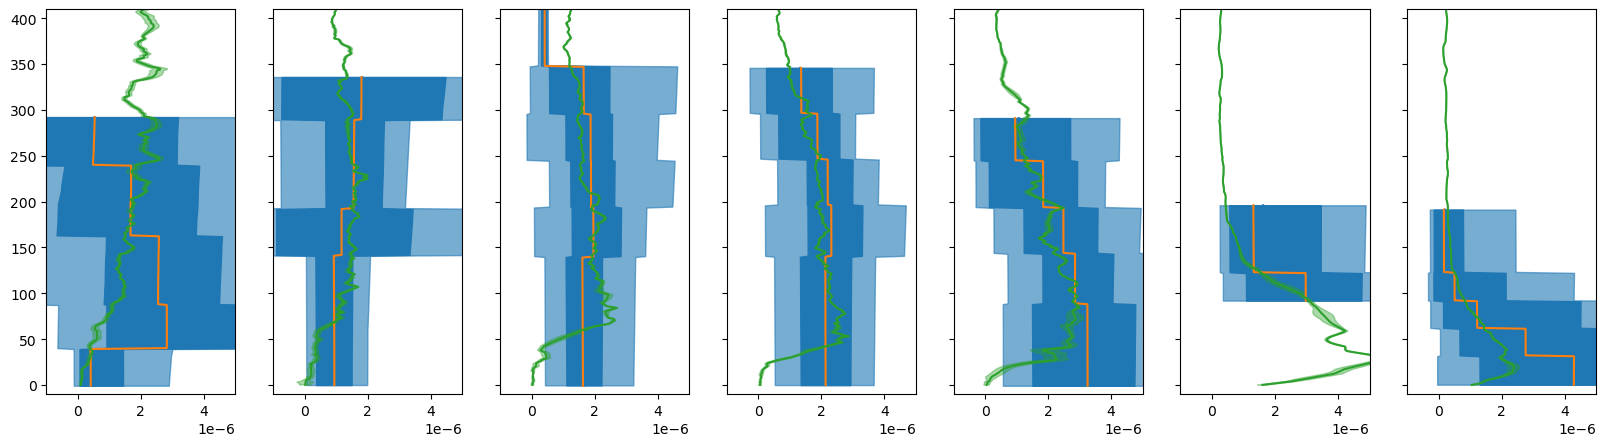

In [219]:
fig, axis = plt.subplots(ncols = 7, sharex = True, sharey = True, figsize = (20,5))

for i, data in enumerate(nsquared_data):
    mab = max_depth_dict[data.location[1]] -  data.index
    mean_N2 = data.mean(axis = "columns")
    # std_N2 = data.std(axis = "columns")

    # axis[i].fill_betweenx(mab, mean_N2-std_N2, mean_N2+std_N2, alpha = 0.4)

    median_N2 = data.median(axis = "columns")
    low_quant = data.quantile(0.05, axis = "columns")
    high_quant = data.quantile(0.95, axis = "columns")
    max_quant = data.quantile(0, axis = "columns")
    min_quant = data.quantile(1, axis = "columns")
    #axis[1,i].plot(median_sal, mab)
    axis[i].fill_betweenx(mab, min_quant, max_quant, alpha = 0.6, facecolor = "tab:blue", edgecolor = "tab:blue")
    axis[i].fill_betweenx(mab, low_quant, high_quant, alpha = 1, color = "tab:blue")
    axis[i].plot(mean_N2, mab)
    axis[i].plot(median_N2, mab)
    #axis[i].fill_betweenx(mab, low_quant, high_quant, alpha = 0.4)

for i,col in enumerate(N_table.columns):
    axis[i].plot(N_table[col]**2, N_table.index, color = "tab:green")
    axis[i].fill_betweenx(N_table.index, N_table[col]**2-N_error_table[col]**2, N_table[col]**2+N_error_table[col]**2, alpha = 0.4, color = "tab:green")
    
axis[0].set_ylim(-10,410)
axis[0].set_xlim(-1e-6,5e-6)

# Look at T and S above the sea floor

In [194]:
# load CTDs
CTDs = src.read_CTDs.load_Joinville_transect_CTDs()
CTDs_grouped = CTDs.groupby("Event")

# load dictionary of closest ctd casts
dict_of_closest_ctds = np.load('../IDEMIX_parametrization/method_results/dict_of_closest_ctds_corrected.npy',allow_pickle='TRUE').item()

COMMON_MAB_AXIS = np.arange(0,800,2)

loading of ../../data/CTD/joinville_transect_ctds_incl_neutral_density.csv was successful
renaming of matlab style columns
Var1 	 index
Event 	 Event
Latitude 	 Latitude
Longitude 	 Longitude
Press_dbar_ 	 Press [dbar]
Sal 	 Sal
Temp__C_ 	 Temp [°C]
AbsoluteSalinity 	 Absolute Salinity
ConservativeTemperature 	 Conservative Temperature
Date_Time 	 Date/Time
DepthWater_m_ 	 Depth water [m]
Expedition 	 Expedition
neutral_density 	 Neutral density [kg m^-3]


In [195]:
pd.DataFrame(dict_of_closest_ctds)

,"(-63.40,-52.29)","(-63.51,-51.64)","(-63.66,-50.81)","(-63.78,-50.09)","(-63.92,-49.27)","(-64.07,-48.38)","(-64.22,-47.49)"
0,PS103_61-1,PS103_59-2,PS129_109_03,PS103_53-1,PS16/153-1,PS103_48-1,PS40/096-1
1,PS129_119_01,PS129_114_02,PS49/011-3,PS40/098-1,PS23/063-3,PS129_103_01,PS77/103-1
2,PS117_82-1,PS16/149-1,PS49/011-2,PS49/013-1,PS18/046-1,PS23/062-4,PS49/017-1
3,PS67/124-1,PS117_85-1,PS49/011-5,PS81/106-1,NaN,PS77/104-1,PS71/209-1
4,PS49/005-1,PS81/514-1,PS71/216-5,PS77/107-1,PS129_105_01,PS67/116-1,PS23/061-1
5,PS103_60-1,PS117_75-1,PS49/011-6,PS23/064-1,PS49/015-1,PS49/016-1,PS18/047-1
6,PS81/512-1,PS77/112-1,PS71/216-4,PS67/120-1,PS40/097-1,PS81/103-1,PS103_46-2
7,PS81/513-1,PS49/006-1,PS49/011-4,PS71/214-1,PS81/104-3,PS71/210-3,PS81/102-1
8,PS71/220-2,PS49/008-1,PS81/516-1,PS18/045-1,PS67/118-1,NaN,PS67/114-1
9,PS129_117_01,PS49/010-1,NaN,PS67/119-1,PS71/212-1,NaN,PS67/115-1


In [196]:
def interp_to_new_index(df, new_index):
    """
    Return a new Series with all columns values interpolated to the new_index values.
    https://stackoverflow.com/questions/48068938/set-new-index-for-pandas-dataframe-interpolating
    """

    # if index is not monotonically increasing, reverse the profile
    if (np.diff(df.index) < 0).any():
        df = pd.Series(index = df.index[::-1], data = df.values[::-1])
        
    df_out = pd.Series(index=new_index, data = np.interp(new_index, df.index, df.values))
    df_out.index.name = df.index.name
    return df_out

In [205]:
ctd_salinity_data = [src.mooring.Mooring(index = COMMON_MAB_AXIS) for mooring in range(7)] 
ctd_temperature_data = [src.mooring.Mooring(index = COMMON_MAB_AXIS) for mooring in range(7)] 

# sort into dataframe
for i,(mooring_loc, closest_ctd_casts) in enumerate(dict_of_closest_ctds.items()):

    ctd_salinity_data[i].location = mooring_loc
    ctd_temperature_data[i].location = mooring_loc
    
    number_of_valid_profiles = (~pd.isna(closest_ctd_casts)).sum()
    
    # for calculating mean N2 profile for each mooring
    for cast_name in closest_ctd_casts:
        if pd.isna(cast_name): continue       
        
        #retrieve data 
        cast = CTDs_grouped.get_group(cast_name)
        
        depth = cast["Depth water [m]"]
        mab = depth.max() - depth  # change vertical coordinate to "meters above ground" or "distance from seafloor"
        in_situ_temp = cast["Temp [°C]"]
        
        try:
            absolute_salinity = cast["Absolute Salinity"]
            assert not np.all(np.isnan(absolute_salinity))
        except AssertionError:
            absolute_salinity = gsw.SA_from_SP(SP = cast["Sal"], p = cast["Press [dbar]"],lon=cast["Longitude"], lat=cast["Latitude"])
            assert not np.all(np.isnan(absolute_salinity))
            
        # interpolation to common mab axis aligns the profiles
        common_in_situ_temp = interp_to_new_index(pd.Series(index = mab.values, data = in_situ_temp.values), COMMON_MAB_AXIS)
        common_salinity = interp_to_new_index(pd.Series(index = mab.values, data = absolute_salinity.values), COMMON_MAB_AXIS)

        ctd_temperature_data[i][cast_name] = common_in_situ_temp
        ctd_salinity_data[i][cast_name] = common_salinity
        
        #cast["Conservative Temperature"]
        #p = cast["Press [dbar]"]
        #lat = cast["Latitude"])
        #depth = -1*gsw.z_from_p(p = N2pressure, lat = cast["Latitude"].mean()) 
        
        #mean_N2 = np.nanmean(N2_array, axis = 0)  #calculating the average
        #median_N2 = np.nanmedian(N2_array, axis = 0)  #calculating the average

In [206]:
ctd_salinity_data[0]

,PS103_61-1,PS129_119_01,PS117_82-1,PS67/124-1,PS49/005-1,PS103_60-1,PS81/512-1,PS81/513-1,PS71/220-2,PS129_117_01,...,PS16/148-1,PS23/069-4,PS18/041-1,PS49/007-3,PS18/042-1,PS77/111-3,PS16/147-1,PS16/146-1,PS103_62-1,PS40/101-1
0,34.772670,34.792308,34.775216,34.787967,34.782012,34.770648,34.775203,34.785272,34.763485,34.781777,...,34.821397,34.785490,34.768224,34.781879,34.780276,34.787018,34.789927,34.768902,34.761922,34.793648
2,34.772605,34.791802,34.775817,34.787872,34.782011,34.771450,34.774675,34.785270,34.763575,34.781978,...,34.820186,34.785490,34.769425,34.781276,34.780175,34.787018,34.791329,34.769500,34.761917,34.793849
4,34.772641,34.791797,34.775513,34.787859,34.782107,34.771457,34.773163,34.785167,34.763394,34.781984,...,34.819542,34.787198,34.769310,34.781979,34.781180,34.787018,34.791263,34.768239,34.762113,34.793758
6,34.770497,34.791886,34.775499,34.787875,34.782192,34.771536,34.772796,34.785064,34.763545,34.781986,...,34.818874,34.786982,34.769109,34.781577,34.782245,34.787198,34.791871,34.767319,34.762098,34.793954
8,34.771126,34.791789,34.775314,34.787974,34.782129,34.771453,34.772228,34.785173,34.763283,34.782066,...,34.818954,34.786645,34.768943,34.781577,34.779561,34.787218,34.792539,34.768073,34.761922,34.794034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,33.611499,34.185688,33.625173,34.163484,34.067681,34.429510,34.630903,34.628486,34.575437,34.570781,...,34.583449,34.583413,34.565078,34.607676,34.600435,34.612022,34.625474,34.574496,33.672733,34.657128
792,33.611499,34.185688,33.625173,34.163484,34.067681,34.412162,34.630903,34.628532,34.571787,34.570515,...,34.583449,34.582110,34.565078,34.607645,34.599485,34.610222,34.622338,34.574496,33.672733,34.651791
794,33.611499,34.185688,33.625173,34.163484,34.067681,34.365861,34.630903,34.628470,34.565504,34.569988,...,34.583449,34.581529,34.565078,34.607538,34.599906,34.607396,34.622788,34.574496,33.672733,34.650071
796,33.611499,34.185688,33.625173,34.163484,34.067681,34.348936,34.630903,34.628382,34.560548,34.568559,...,34.583449,34.584451,34.565078,34.607617,34.598965,34.606480,34.622469,34.574496,33.672733,34.646632


In [207]:
test = pd.Series(index=mab,data=in_situ_temp.values)
test2 = interp_to_new_index(test,COMMON_MAB_AXIS)

<Axes: xlabel='Depth water [m]'>

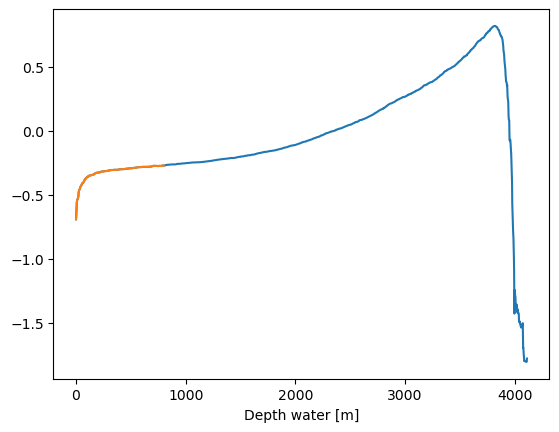

In [208]:
test.plot()
test2.plot()

In [201]:
outliers = []
for i,data in enumerate(ctd_temperature_data): 
    median_temp = data.median(axis = "columns")
    for col in data.columns:
        if (data[col] -  median_temp).std() < 0.5: continue
        if i==0: continue
        outliers.append(col)
        print(f"\t{col}, {(data[col] -  median_temp).std()}")

# for i,data in enumerate(ctd_temperature_data): 
#     mab = data.index
#     mean_temp = data.mean(axis = "columns")
#     #low_quant = data.quantile(0.05, axis = "columns")
#     #high_quant = data.quantile(0.95, axis = "columns")
#     axis[0,i].plot(mean_temp, mab, "k")
#     for col in data.columns:
#         if col in outliers: continue
#         axis[0,i].plot(data[col], mab, "k", alpha = 0.2)


# for i,data in enumerate(ctd_salinity_data):

In [202]:
f"{outliers =}"

'outliers =[]'

(34.74, 34.84)

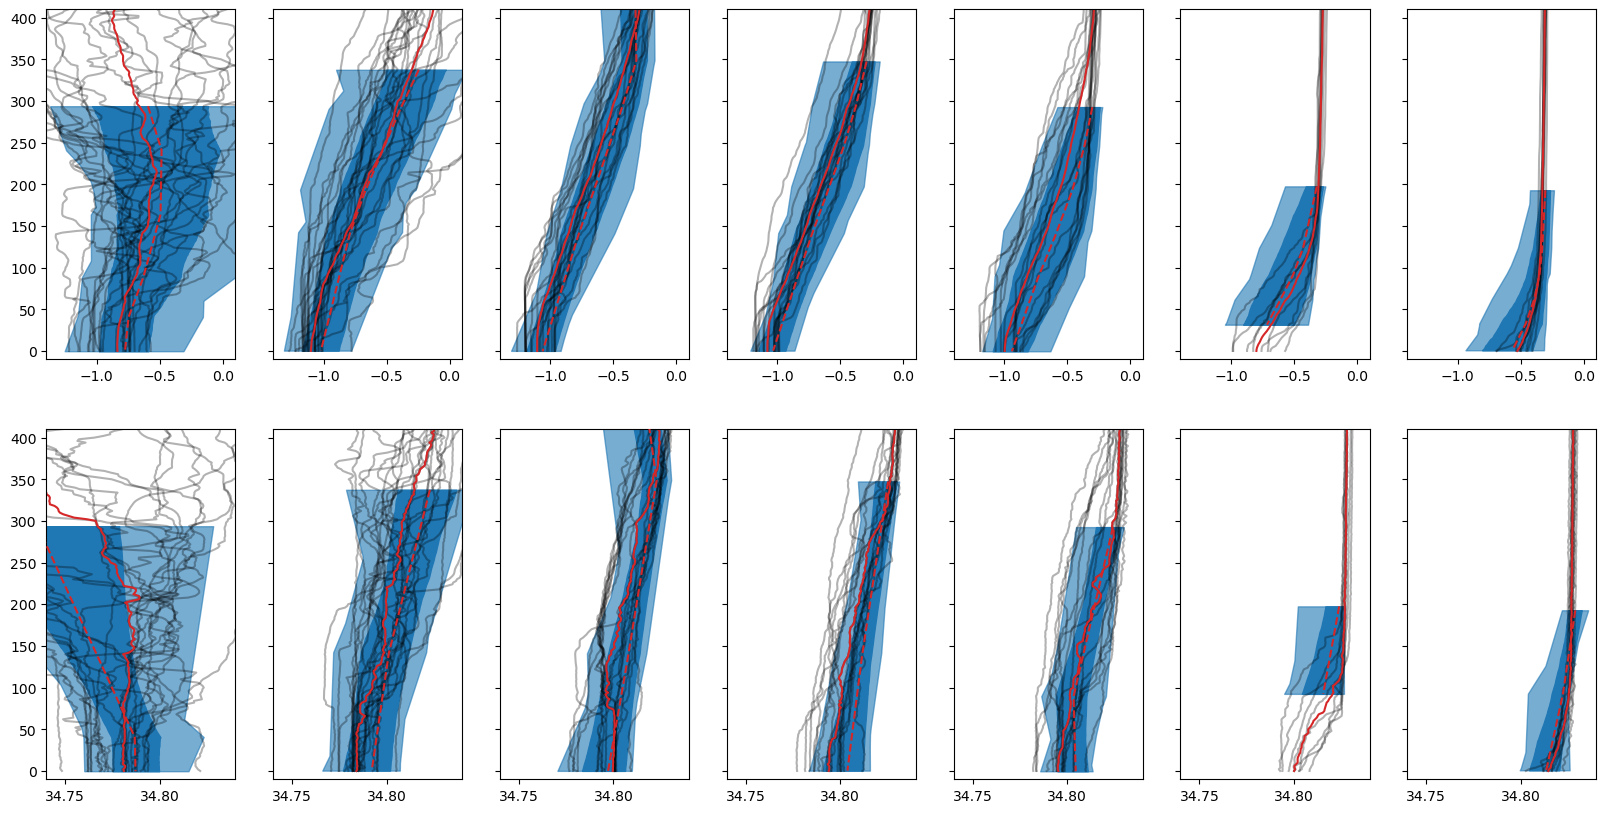

In [225]:
fig, axis = plt.subplots(nrows = 2, ncols = 7, sharex = "row", sharey = True, figsize = (20,10))

# plot mooring temperature
for i, data in enumerate(temperature_data):
    mab = max_depth_dict[data.location[1]] -  data.index    
    #median_temp = data.median(axis = "columns")
    low_quant = data.quantile(0.05, axis = "columns")
    high_quant = data.quantile(0.95, axis = "columns")
    max_quant = data.quantile(0, axis = "columns")
    min_quant = data.quantile(1, axis = "columns")

    #axis[0,i].plot(median_temp, mab)
    axis[0,i].fill_betweenx(mab, min_quant, max_quant, alpha = 0.6, color = "tab:blue")
    axis[0,i].fill_betweenx(mab, low_quant, high_quant, alpha = 1, color = "tab:blue")
    #axis[0,i].plot(min_quant, mab,"k",lw = 0.7)
    #axis[0,i].plot(max_quant, mab,"k",lw = 0.7)
    
    mean_temp = data.mean(axis = "columns")
    # std_temp = data.std(axis = "columns")
    axis[0,i].plot(mean_temp, mab, ls = "--", zorder = 5, color = "tab:red")
    # axis[0,i].fill_betweenx(mab, mean_temp-std_temp, mean_temp+std_temp, alpha = 0.4)


# plot mooring salinity     
for i, data in enumerate(salinity_data):
    mab = max_depth_dict[data.location[1]] -  data.index
    
    median_sal = data.median(axis = "columns")
    low_quant = data.quantile(0.05, axis = "columns")
    high_quant = data.quantile(0.95, axis = "columns")
    max_quant = data.quantile(0, axis = "columns")
    min_quant = data.quantile(1, axis = "columns")
    #axis[1,i].plot(median_sal, mab)
    axis[1,i].fill_betweenx(mab, min_quant, max_quant, alpha = 0.6, facecolor = "tab:blue", edgecolor = "tab:blue")
    axis[1,i].fill_betweenx(mab, low_quant, high_quant, alpha = 1, color = "tab:blue")
    #axis[1,i].plot(min_quant, mab,"k",lw = 0.7)
    #axis[1,i].plot(max_quant, mab,"k",lw = 0.7)
    
    mean_sal = data.mean(axis = "columns")
    # std_sal = data.std(axis = "columns")
    axis[1,i].plot(mean_sal, mab, ls = "--", zorder = 5, color = "tab:red")
    # axis[1,i].fill_betweenx(mab, mean_sal-std_sal, mean_sal+std_sal, alpha = 0.4)

for i,data in enumerate(ctd_temperature_data): 
    mab = data.index
    mean_temp = data.mean(axis = "columns")
    #low_quant = data.quantile(0.05, axis = "columns")
    #high_quant = data.quantile(0.95, axis = "columns")

    for col in data.columns:
        if col in outliers: 
            axis[0,i].plot(data[col], mab, "tab:orange", alpha = 1, zorder = 0)
            continue
        axis[0,i].plot(data[col], mab, "k", alpha = 0.3)
    axis[0,i].plot(mean_temp, mab, "tab:red")

for i,data in enumerate(ctd_salinity_data):
    mab = data.index
    median_sal = data.median(axis = "columns")
    mean_sal = data.median(axis = "columns")
    low_quant = data.quantile(0.05, axis = "columns")
    high_quant = data.quantile(0.95, axis = "columns")

    #axis[1,i].fill_betweenx(mab, low_quant, high_quant, alpha = 0.4)
    for col in data.columns:
        if col in outliers: 
            axis[1,i].plot(data[col], mab, "tab:orange", alpha = 1, zorder = 0)
            continue
        axis[1,i].plot(data[col], mab, "k", alpha = 0.3)
    axis[1,i].plot(mean_sal, mab, "tab:red")
    

axis[0,0].set_ylim(-10,410)
axis[0,0].set_xlim(-1.4,0.1)
axis[1,0].set_xlim(34.74,34.84)

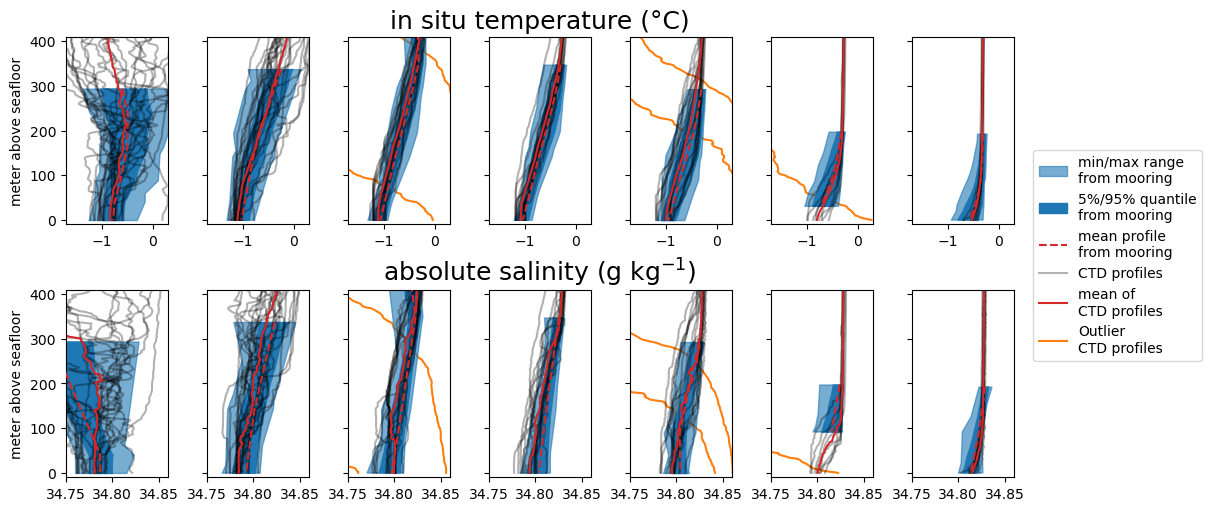

In [268]:
OUTLIERS = ['PS71/216-1', 'PS40/099-1', 'PS49/015-2', 'PS71/212-3', 'PS71/210-2']

fig, axis = plt.subplots(nrows = 2, ncols = 7, sharex = "row", sharey = True, figsize = (12,5), constrained_layout = True)

# plot mooring temperature
for i, data in enumerate(temperature_data):
    mab = max_depth_dict[data.location[1]] -  data.index    
    #median_temp = data.median(axis = "columns")
    low_quant = data.quantile(0.05, axis = "columns")
    high_quant = data.quantile(0.95, axis = "columns")
    max_quant = data.quantile(0, axis = "columns")
    min_quant = data.quantile(1, axis = "columns")

    #axis[0,i].plot(median_temp, mab)
    axis[0,i].fill_betweenx(mab, min_quant, max_quant, alpha = 0.6, color = "tab:blue", label = "min/max range\nfrom mooring")
    axis[0,i].fill_betweenx(mab, low_quant, high_quant, alpha = 1, color = "tab:blue", label = "5%/95% quantile\nfrom mooring")
    #axis[0,i].plot(min_quant, mab,"k",lw = 0.7)
    #axis[0,i].plot(max_quant, mab,"k",lw = 0.7)
    
    mean_temp = data.mean(axis = "columns")
    # std_temp = data.std(axis = "columns")
    axis[0,i].plot(mean_temp, mab, ls = "--", zorder = 5, color = "tab:red", label = "mean profile\nfrom mooring")
    # axis[0,i].fill_betweenx(mab, mean_temp-std_temp, mean_temp+std_temp, alpha = 0.4)


# plot mooring salinity     
for i, data in enumerate(salinity_data):
    mab = max_depth_dict[data.location[1]] -  data.index
    
    median_sal = data.median(axis = "columns")
    low_quant = data.quantile(0.05, axis = "columns")
    high_quant = data.quantile(0.95, axis = "columns")
    max_quant = data.quantile(0, axis = "columns")
    min_quant = data.quantile(1, axis = "columns")
    #axis[1,i].plot(median_sal, mab)
    axis[1,i].fill_betweenx(mab, min_quant, max_quant, alpha = 0.6, facecolor = "tab:blue", edgecolor = "tab:blue", label = "min/max range\nfrom mooring")
    axis[1,i].fill_betweenx(mab, low_quant, high_quant, alpha = 1, color = "tab:blue", label = "5%/95% quantile\nfrom mooring")
    #axis[1,i].plot(min_quant, mab,"k",lw = 0.7)
    #axis[1,i].plot(max_quant, mab,"k",lw = 0.7)
    
    mean_sal = data.mean(axis = "columns")
    # std_sal = data.std(axis = "columns")
    axis[1,i].plot(mean_sal, mab, ls = "--", zorder = 5, color = "tab:red", label = "mean profile\nfrom mooring")
    # axis[1,i].fill_betweenx(mab, mean_sal-std_sal, mean_sal+std_sal, alpha = 0.4)

for i,data in enumerate(ctd_temperature_data): 
    mab = data.index
    mean_temp = data.mean(axis = "columns")
    #low_quant = data.quantile(0.05, axis = "columns")
    #high_quant = data.quantile(0.95, axis = "columns")

    for col in data.columns:
        axis[0,i].plot(data[col], mab, "k", alpha = 0.3, label = "CTD profiles")
    axis[0,i].plot(mean_temp, mab, "tab:red", label = "mean of\nCTD profiles")

for i,data in enumerate(ctd_salinity_data):
    mab = data.index
    median_sal = data.median(axis = "columns")
    mean_sal = data.median(axis = "columns")
    low_quant = data.quantile(0.05, axis = "columns")
    high_quant = data.quantile(0.95, axis = "columns")

    #axis[1,i].fill_betweenx(mab, low_quant, high_quant, alpha = 0.4)
    for col in data.columns:
        axis[1,i].plot(data[col], mab, "k", alpha = 0.3, label = "CTD profiles")
    axis[1,i].plot(mean_sal, mab, "tab:red", label = "mean of\nCTD profiles")


# recompute with outliers
recomputed_ctd_salinity_data = [src.mooring.Mooring(index = COMMON_MAB_AXIS) for mooring in range(7)] 
recomputed_ctd_temperature_data = [src.mooring.Mooring(index = COMMON_MAB_AXIS) for mooring in range(7)] 

old_dict_of_closest_ctds = np.load('../IDEMIX_parametrization/method_results/dict_of_closest_ctds.npy',allow_pickle='TRUE').item()
# sort into dataframe
for i,(mooring_loc, closest_ctd_casts) in enumerate(old_dict_of_closest_ctds.items()):

    recomputed_ctd_salinity_data[i].location = mooring_loc
    recomputed_ctd_temperature_data[i].location = mooring_loc
    
    for cast_name in closest_ctd_casts:   
        if cast_name not in OUTLIERS: continue
        #retrieve data 
        cast = CTDs_grouped.get_group(cast_name)
        
        depth = cast["Depth water [m]"]
        mab = depth.max() - depth  # change vertical coordinate to "meters above ground" or "distance from seafloor"
        in_situ_temp = cast["Temp [°C]"]
        
        try:
            absolute_salinity = cast["Absolute Salinity"]
            assert not np.all(np.isnan(absolute_salinity))
        except AssertionError:
            absolute_salinity = gsw.SA_from_SP(SP = cast["Sal"], p = cast["Press [dbar]"],lon=cast["Longitude"], lat=cast["Latitude"])
            assert not np.all(np.isnan(absolute_salinity))
            
        # interpolation to common mab axis aligns the profiles
        common_in_situ_temp = interp_to_new_index(pd.Series(index = mab.values, data = in_situ_temp.values), COMMON_MAB_AXIS)
        common_salinity = interp_to_new_index(pd.Series(index = mab.values, data = absolute_salinity.values), COMMON_MAB_AXIS)

        recomputed_ctd_temperature_data[i][cast_name] = common_in_situ_temp
        recomputed_ctd_salinity_data[i][cast_name] = common_salinity
        
        #cast["Conservative Temperature"]
        #p = cast["Press [dbar]"]
        #lat = cast["Latitude"])
        #depth = -1*gsw.z_from_p(p = N2pressure, lat = cast["Latitude"].mean()) 
        
        #mean_N2 = np.nanmean(N2_array, axis = 0)  #calculating the average
        #median_N2 = np.nanmedian(N2_array, axis = 0)  #calculating the average

for i,data in enumerate(recomputed_ctd_temperature_data): 
    mab = data.index
    for col in data.columns:
        if col in OUTLIERS: 
            axis[0,i].plot(data[col], mab, "tab:orange", alpha = 1, zorder = 0, label = "Outlier\nCTD profiles")

for i,data in enumerate(recomputed_ctd_salinity_data):
    mab = data.index
    for col in data.columns:
        if col in OUTLIERS: 
            axis[1,i].plot(data[col], mab, "tab:orange", alpha = 1, zorder = 0, label = "Outlier\nCTD profiles")

# axis[0,0].set_ylim(-10,510)
# axis[0,0].set_xlim(-1.8,0.6)
# axis[1,0].set_xlim(34.65,34.86)
axis[0,0].set_ylim(-10,410)
axis[0,0].set_xlim(-1.7,0.3)
axis[1,0].set_xlim(34.75,34.86)

axis[0,0].set_ylabel("meter above seafloor")
axis[1,0].set_ylabel("meter above seafloor")
axis[0,0].set_xlim(-1.7,0.3)
axis[1,0].set_xlim(34.75,34.86)

axis[0,3].set_title("in situ temperature (°C)", fontsize = 18)
axis[1,3].set_title("absolute salinity (g kg$^{-1}$)", fontsize = 18)

handles, labels = [],[]
for ax in axis.flatten():
    handles_, labels_ = ax.get_legend_handles_labels()
    handles += handles_
    labels += labels_
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc="outside right")
fig.savefig("./stratification_comparison_review.png", dpi = 300)